In [1]:
# env init
import os
import pickle

import cv2
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

os.environ["LOKY_MAX_CPU_COUNT"] = "8"

In [2]:
# origin part
env = "imbalance"

# path init
# check env dir if exist in working path
if not os.path.exists("./" + env):
    os.makedirs("./" + env)
working_path = "./" + env
print("working path: ", working_path)
# check img dir if exist in working path
if not os.path.exists(working_path + "/img"):
    print(working_path+"img dir not exist, create it")
    os.makedirs(working_path + "/img")
# read df csv
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

categories = [
    d
    for d in os.listdir("./Aerial_Landscapes")
    if os.path.isdir(os.path.join("./Aerial_Landscapes", d))
]  # because original dataset already split imgs into folders with specific names, so use it as label

working path:  ./imbalance


In [3]:
# prepare the dataframe

# get a copy of the original dataframe, prevent overwriting the original dataframe
train_df_imbalance = train_df.copy()
# set rules for unbalancing
major_part = [
    "River",
    "Airport",
    "Beach",
    "Port",
    "Agriculture",
    "Desert",
    "Lake",
    "Grassland",
    "Highway",
    "Agriculture",
]

minor_part = [
    # due to they have high accuracy in the original dataset, so try to imbalance them for testing model robustness
    "City",
    "Parking",
    "Forest",
    "Mountain",
    "Residential",
    "Railway",
]

image_imbalance_paths = []
image_imbalance_labels = []

print("Unbalancing the images..., total count: ", len(train_df_imbalance))
# unbalance the images in the dataframe
for i in range(len(train_df_imbalance)):
    image_path = train_df_imbalance.iloc[i]["image_path"]
    image_label = train_df_imbalance.iloc[i]["label"]
    image = cv2.imread(image_path)

    if image is None:
        print(f"Error reading image {image_path}")
        continue

    # unbalance the image
    if image_label in major_part and np.random.rand() < 0.2:
        print(f"Unbalancing {image_label} image {i} in major part")
        continue
    elif image_label in minor_part and np.random.rand() < 0.8:
        print(f"Unbalancing {image_label} image {i} in minor part")
        continue

    # save the imbalance image to the dataframe
    imbalance_image_path = os.path.join(working_path + "/img", f"{image_label}_{i}.jpg")
    # replace \ with / in the path
    imbalance_image_path = imbalance_image_path.replace("\\", "/")
    cv2.imwrite(
        imbalance_image_path, image
    )  # save the imbalance image to the directory
    image_imbalance_paths.append(imbalance_image_path)
    image_imbalance_labels.append(image_label)
print("Unbalancing the images done! Total count: ", len(image_imbalance_paths))

# add the imbalance images to the dataframe
train_df_imbalance = pd.DataFrame(
    {"image_path": image_imbalance_paths, "label": image_imbalance_labels}
)

# save the dataframe to csv
train_df_imbalance.to_csv(working_path + "/train_imbalance.csv", index=False)
print("count for each category:" + str(train_df_imbalance["label"].value_counts()))
# ETA 25s

Unbalancing the images..., total count:  9600
Unbalancing Residential image 1 in minor part
Unbalancing Residential image 2 in minor part
Unbalancing Mountain image 3 in minor part
Unbalancing Mountain image 11 in minor part
Unbalancing Residential image 12 in minor part
Unbalancing Forest image 15 in minor part
Unbalancing City image 16 in minor part
Unbalancing River image 19 in major part
Unbalancing Forest image 20 in minor part
Unbalancing Port image 23 in major part
Unbalancing Residential image 26 in minor part
Unbalancing City image 27 in minor part
Unbalancing Mountain image 30 in minor part
Unbalancing Beach image 32 in major part
Unbalancing Parking image 33 in minor part
Unbalancing Forest image 35 in minor part
Unbalancing Mountain image 38 in minor part
Unbalancing Parking image 39 in minor part
Unbalancing City image 42 in minor part
Unbalancing Port image 48 in major part
Unbalancing Port image 51 in major part
Unbalancing Mountain image 52 in minor part
Unbalancing For

In [4]:
# show the imbalance count of images
category_counts = train_df_imbalance["label"].value_counts()
print(category_counts)
cate_address = train_df_imbalance["image_path"].values
print(cate_address)

label
River          532
Beach          524
Desert         516
Agriculture    513
Grassland      505
Highway        503
Airport        498
Lake           498
Port           491
Forest         135
Parking        126
Railway        126
Mountain       124
City           121
Residential    109
Name: count, dtype: int64
['./imbalance/img/Airport_0.jpg' './imbalance/img/Grassland_4.jpg'
 './imbalance/img/Port_5.jpg' ... './imbalance/img/Agriculture_9596.jpg'
 './imbalance/img/Airport_9598.jpg' './imbalance/img/Port_9599.jpg']


In [5]:
# SIFT for getting keypoints and descriptors
sift_imbalance = cv2.SIFT_create()
# save sift descriptors and keypoints
sift_imbalance_descriptors_list = []
# start sift, only on train df imbalance
for index, row in train_df_imbalance.iterrows():
    image_path = row["image_path"]
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_imbalance.detectAndCompute(gray_image, None)
    if descriptors is not None and descriptors.ndim == 2:
        sift_imbalance_descriptors_list.append(descriptors)
# show number of keypoints and descriptors
print("###imbalance TRAIN DF###")
print(f"Number of descriptors: {len(sift_imbalance_descriptors_list)}")
# save
with open(working_path + "/sift_imbalance_descriptors_list.pkl", "wb") as f:
    pickle.dump(sift_imbalance_descriptors_list, f)
# load sift descriptors and keypoints
# ETA 1m7s
# eta 2M2.2S

###imbalance TRAIN DF###
Number of descriptors: 5263


In [6]:
# build boW

# flatten the list of descriptors and fit kmeans
if sift_imbalance_descriptors_list:
    all_descriptors = np.vstack(sift_imbalance_descriptors_list)
k = 300  # number of clusters
kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
kmeans.fit(all_descriptors)

def get_bow_histogram(descriptors, kmeans):
    if descriptors is not None:
        # predict the cluster for each descriptor
        cluster_indices = kmeans.predict(descriptors)
        # count the occurrences of each cluster index
        histogram, _ = np.histogram(cluster_indices, bins=np.arange(k + 1), density=True)
        return histogram
    else:
        # if descriptors is None, return a zero histogram
        return np.zeros(k)

def get_bow_features(dataframe, image_path, kmeans):
    x_temp = []
    y_temp = []
    for index, row in dataframe.iterrows():
        image_path = row["image_path"]
        image = cv2.imread(image_path)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift_imbalance.detectAndCompute(gray_image, None)

        # get the histogram for the image
        histogram = get_bow_histogram(descriptors, kmeans)

        x_temp.append(histogram)
        y_temp.append(row["label"])
    return np.array(x_temp), np.array(y_temp)

x_train = []
y_train = []

for index, row in train_df_imbalance.iterrows():
    image_path = row["image_path"]
    image = cv2.imread(image_path)
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift_imbalance.detectAndCompute(gray_image, None)

    # get the histogram for the image
    histogram = get_bow_histogram(descriptors, kmeans)
    x_train.append(histogram)
    y_train.append(row["label"])

# convert to numpy array
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test, y_test = get_bow_features(test_df, image_path, kmeans)

# ETA 3m2s,3m3s

d:\Dev\anaconda3\envs\SIFT_KNN\Lib\site-packages\sklearn\cluster\_kmeans.py:1952: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


In [7]:
# save to disk
np.save(working_path + "/x_train.npy", x_train)
np.save(working_path + "/y_train.npy", y_train)
np.save(working_path + "/x_test.npy", x_test)
np.save(working_path + "/y_test.npy", y_test)

In [8]:
# start training, by KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
# test the model on test set
y_pred = knn.predict(x_test)
# save knn model
joblib.dump(knn, working_path + "/knn_model.pkl")
np.save(working_path + "/y_pred.npy", y_pred)
np.save(working_path + "/y_test.npy", y_test)

Accuracy: 0.49
              precision    recall  f1-score   support

 Agriculture       0.57      0.51      0.54       160
     Airport       0.27      0.55      0.36       160
       Beach       0.51      0.19      0.28       160
        City       0.43      0.74      0.54       160
      Desert       0.50      0.51      0.50       160
      Forest       0.74      0.81      0.78       160
   Grassland       0.59      0.38      0.46       160
     Highway       0.37      0.57      0.45       160
        Lake       0.27      0.32      0.29       160
    Mountain       0.65      0.54      0.59       160
     Parking       0.94      0.55      0.69       160
        Port       0.75      0.45      0.56       160
     Railway       0.52      0.50      0.51       160
 Residential       0.75      0.45      0.56       160
       River       0.26      0.24      0.25       160

    accuracy                           0.49      2400
   macro avg       0.54      0.49      0.49      2400
weighted av

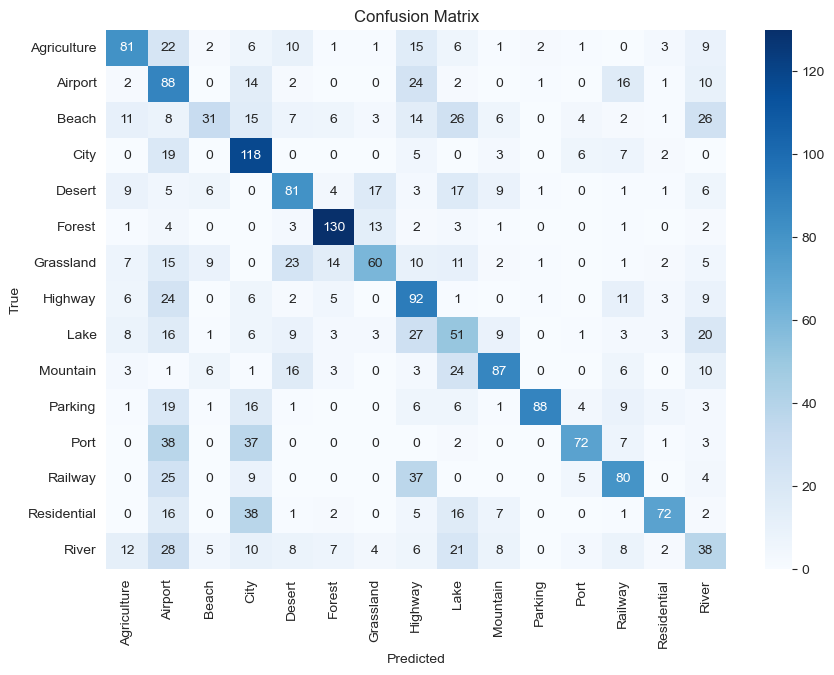

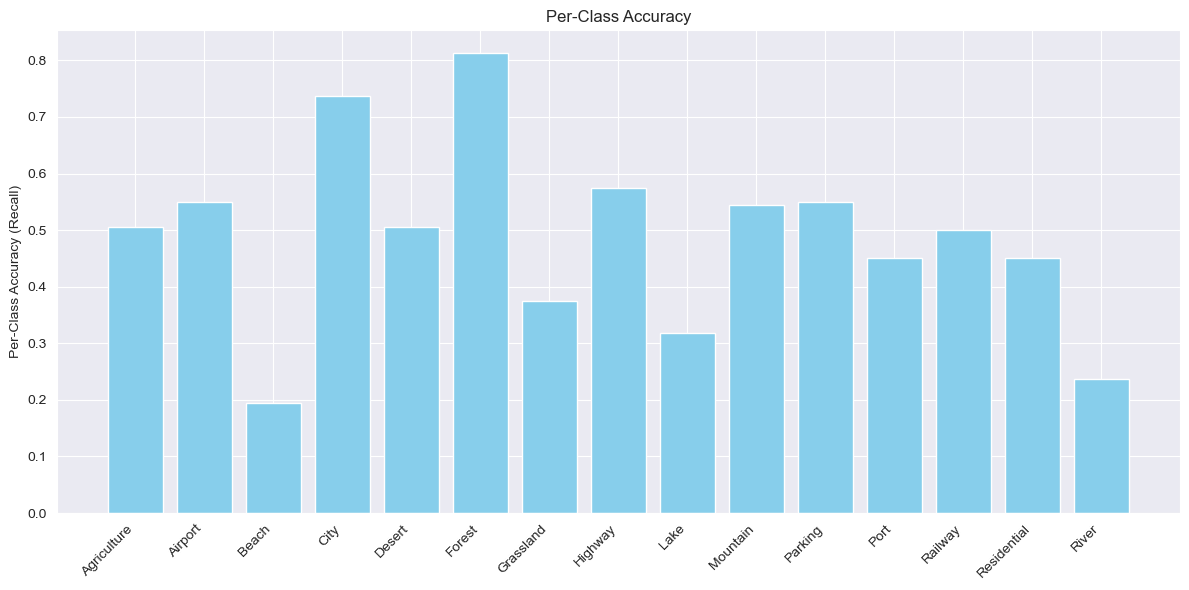

In [9]:
# show results by plt

# show accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=categories))

# show confusion matrix
plt.figure(figsize=(10, 7))
cm = confusion_matrix(y_test, y_pred, labels=categories)
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=categories,
    yticklabels=categories,
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# show accuracy by each cateqory,using bar chart via plt
# x axis catecory, y axis accuracy
per_class_acc = np.diag(cm) / cm.sum(axis=1)
plt.figure(figsize=(12, 6))
plt.bar(categories, per_class_acc, color="skyblue")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Per-Class Accuracy (Recall)")
plt.title("Per-Class Accuracy")
plt.tight_layout()
plt.show()

In [10]:
print("count for each category:" + str(train_df_imbalance["label"].value_counts()))
print("confusion matrix:")
print(confusion_matrix(y_test, y_pred, labels=categories))

count for each category:label
River          532
Beach          524
Desert         516
Agriculture    513
Grassland      505
Highway        503
Airport        498
Lake           498
Port           491
Forest         135
Parking        126
Railway        126
Mountain       124
City           121
Residential    109
Name: count, dtype: int64
confusion matrix:
[[ 81  22   2   6  10   1   1  15   6   1   2   1   0   3   9]
 [  2  88   0  14   2   0   0  24   2   0   1   0  16   1  10]
 [ 11   8  31  15   7   6   3  14  26   6   0   4   2   1  26]
 [  0  19   0 118   0   0   0   5   0   3   0   6   7   2   0]
 [  9   5   6   0  81   4  17   3  17   9   1   0   1   1   6]
 [  1   4   0   0   3 130  13   2   3   1   0   0   1   0   2]
 [  7  15   9   0  23  14  60  10  11   2   1   0   1   2   5]
 [  6  24   0   6   2   5   0  92   1   0   1   0  11   3   9]
 [  8  16   1   6   9   3   3  27  51   9   0   1   3   3  20]
 [  3   1   6   1  16   3   0   3  24  87   0   0   6   0  10]
 [  1  19  